In [5]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dense, Flatten, SimpleRNN, 
                                     LSTM, GRU, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler

tf.__version__

'2.1.0'

In [6]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/data/master/em_admits_ts.csv'
em_admits = pd.read_csv(url)
date_str = em_admits['month_year'].str[:3] + ' 20' + em_admits['month_year'].str[-2:]
date_str.name = 'date'
em_admits = em_admits.set_index(pd.to_datetime(date_str))
em_admits.index.freq = 'MS'
em_admits = em_admits.drop(columns=['month_year'])
admit_rate = em_admits['em_admits'] / em_admits.index.days_in_month


In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
# def sliding_window(train, window_size=2, horizon=1):
#     '''
#     sliding window.
    
#     Parameters:
#     --------
#     train: array-like
#         training data for time series method
    
#     window_size: int, optional (default=2)
#         lookback - how much lagged data to include.
        
#     horizon: int, optional (default=1)
#         number of observations ahead to predict
#             ?
#     Returns:
#         array-like, array-like
    
#         preprocessed X, preprocessed Y
#     '''
#     tabular_X = []
#     tabular_y = []
    
#     for i in range(0, len(train) - window_size - horizon):
#         X_train = train[i:window_size+i]
#         y_train = train[i+window_size+horizon-1]
#         tabular_X.append(X_train)
#         tabular_y.append(y_train)
       
#     return np.asarray(tabular_X).reshape(-1, window_size, 1), np.asarray(tabular_y)

In [9]:
def sliding_window(train, window_size=2, horizon=2):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=2)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        #we use list slicing to return a vector of training for y_train
        y_train = train[i+window_size:i+window_size+horizon]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
    
    return np.asarray(tabular_X), np.array(tabular_y)

In [46]:
#preprocess time series training and test sets
WINDOW_SIZE = 12
HORIZON = 12
TRAIN_LENGTH = 56

scaler = MinMaxScaler(feature_range=(-1, 1))

#I am scaling on admit_rate because this will include the first 12 lags 
#not in y_train
scaler.fit(admit_rate.iloc[:-12].to_numpy().reshape(-1, 1))
admit_rate_adj = scaler.transform(admit_rate.to_numpy().reshape(-1, 1))

#for clarity repeat the preprocessing
X_train, y_train = sliding_window(admit_rate_adj, 
                                  window_size=WINDOW_SIZE,
                                  horizon=HORIZON)

X_train = X_train.reshape(-1, WINDOW_SIZE, 1)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

In [48]:
def get_simple_rnn(window_size, n_units=10, activation='tanh'):
    model = Sequential()
    model.add(Input(shape=(window_size, 1)))
    model.add(SimpleRNN(n_units, activation=activation))
    model.add(Dense(window_size))
    model.compile(optimizer=Adam(lr=0.01), loss='mse')
    return model

In [199]:
def get_lstm(window_size, n_units=10, activation='tanh'):
    model = Sequential()
    model.add(Input(shape=(window_size, 1)))
    model.add(Conv1D(24, 6))
    model.add(LSTM(n_units, activation=activation))
    #model.add(GlobalMaxPool1D())
    model.add(Dense(window_size))
    model.compile(optimizer=Adam(lr=0.01), loss='mse')
    return model

In [210]:
model = get_simple_rnn(12, n_units=100, activation='tanh')
#model = get_lstm(WINDOW_SIZE, n_units=150, activation='relu')

In [211]:
N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=20,
                  restore_best_weights=True)

history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

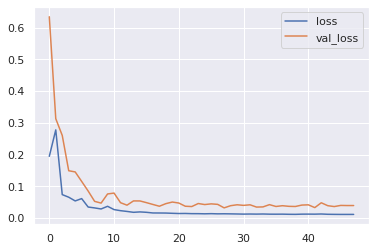

In [212]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [213]:
#plt.plot(admit_rate_adj[:-12], label='ground truth')
#plt.plot(model.predict(X_train), label='NN fitted')
#plt.legend();

In [214]:
def vector_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X.reshape(1, WINDOW_SIZE, -1))[0]
        y_preds.append(y_pred)
        
        #current_X = np.roll(current_X, shift=-h)
        #current_X[-h] = y_pred.copy()
        current_X = y_pred.copy()

    return np.concatenate(np.array(y_preds))

In [215]:
def plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds):  
    
    #create series
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    padding = np.full(len(fitted_values), np.NAN)

    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

In [216]:
y_train[0].shape

(12, 1)

In [217]:
#predict next 24 months and plot (2 vector lengths)
H = 36
VECTORS_AHEAD = H // WINDOW_SIZE
y_preds = vector_iterative_forecast(model, X_test[0], h=VECTORS_AHEAD)

#y_preds = model.predict(X_test[0].reshape(-1, WINDOW_SIZE, 1))
y_preds = scaler.inverse_transform(y_preds.reshape(-1, 1))

#plot_nn_prediction_results(model, X_train, y_train, y_test[0], y_preds)

In [218]:
rmse_rnn = rmse(scaler.inverse_transform(y_test[0].reshape(-1, 1)), y_preds.T[:H])[0]

print(f'rmse RNN: {rmse_rnn:.2f}')

rmse RNN: 346.48


In [219]:
y_test[12].T[0]

array([0.12919558, 0.40681194, 0.43244948, 0.30960817, 0.11494966,
       0.36521737, 0.51567898, 0.76522328, 0.62767591, 0.70506688,
       0.73333766, 0.70537692])

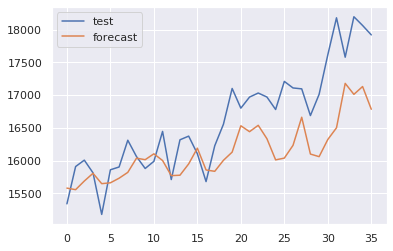

In [209]:
y_test_to_plot = []
for i in range(VECTORS_AHEAD):
    y_test_to_plot.append(y_test[WINDOW_SIZE*i])
y_test_to_plot = np.concatenate(y_test_to_plot)

y_test_to_plot = scaler.inverse_transform(y_test_to_plot.reshape(-1, 1))   
plt.plot(y_test_to_plot, label='test')
plt.plot(y_preds, label='forecast')
plt.legend()

In [220]:
# Exercise create an ensemble of SimpleRNNs

In [242]:
#set tensorflow random seed for repeatability
tf.random.set_seed(1066)

N_MODELS = 30
N_EPOCHS = 100
N_UNITS = 100
H = 12
VECTORS_AHEAD = H // WINDOW_SIZE

es = EarlyStopping(monitor='loss', patience=10)
BATCH_SIZE = 32

models = []
for n in range(N_MODELS):
    #SimpleRNN model
    model_n = model = get_simple_rnn(WINDOW_SIZE, 
                                     n_units=N_UNITS, 
                                     activation='tanh')

    #fit model silently
    history = model_n.fit(x=X_train, 
                          y=y_train, 
                          epochs=N_EPOCHS,
                          verbose=0, 
                          callbacks=[es], 
                          batch_size=BATCH_SIZE)

    #this will overwrite pre-trained models.
    #model_n.save(f'output/mlp_ensemble_{n}.h5')
    models.append(model_n)

In [243]:
#this code will take a few seconds to execute
H = 1
e_preds = []
for model in models:
    y_preds = vector_iterative_forecast(model, X_test[0], h=H)
    e_preds.append(y_preds)
    
e_preds = np.array(e_preds)

In [244]:
e_preds = np.asarray(e_preds)
e_preds_tran = scaler.inverse_transform(e_preds).T
y_preds_mdn = np.percentile(e_preds_tran.T, 50, axis=0)
y_preds_2_5 = np.percentile(e_preds_tran.T, 2.5, axis=0)
y_preds_97_5 = np.percentile(e_preds_tran.T, 97.5, axis=0)
y_preds_mdn.shape

(12,)

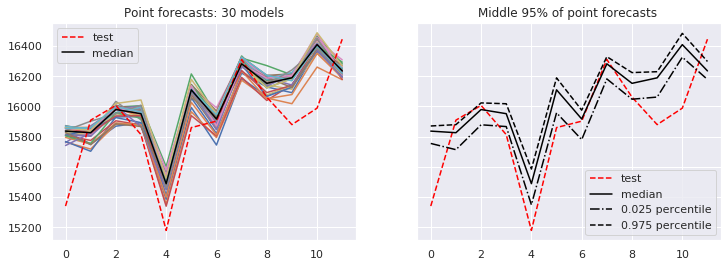

In [245]:
#plot the individual forecasts and the median

fig,ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].plot(e_preds_tran)
ax[0].plot(scaler.inverse_transform(y_test[0]), label='test', linestyle='--', 
         color='red')
ax[0].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[0].legend()
ax[0].set_title(f'Point forecasts: {N_MODELS} models')

ax[1].plot(scaler.inverse_transform(y_test[0]), label='test', linestyle='--', 
         color='red')
ax[1].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[1].plot(y_preds_2_5, label='0.025 percentile', linestyle='-.', color='black')
ax[1].plot(y_preds_97_5, label='0.975 percentile', linestyle='--', color='black')

ax[1].set_title(f'Middle 95% of point forecasts ')
ax[1].legend();

In [246]:
rmse_rnn_mdn = rmse(scaler.inverse_transform(y_test[0].reshape(-1, 1)), y_preds_mdn)[0]

print(f'rmse RNN: {rmse_rnn_mdn:.2f}')

rmse RNN: 340.26
